In [42]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import pandas as pd
import datetime as dt
import pydot
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.tree import export_graphviz
from sklearn import tree
import sys
from graphviz import Source

mask_directory = '/Users/kathum/Research/COPEX/sink_region_files/masks'
WAM_files = '/Volumes/LaCie_10TB_Keys_KH/era5/output/backtrack/co_altclimate_nfr_2000_2023/'
sink_region_name = 'nfr'

## Open Labels and Inputs

In [43]:
# MODIFY----------
label_path = '/Users/kathum/Classes/fall_2024/Data_driven Analysis/Data_Driven_Prediction/nfr_daily_precip.csv'
#input_path = '/Users/kathum/Classes/fall_2024/Data_driven Analysis/Data_Driven_Prediction/nfr_daily_e_track.csv'
input_path = '/Users/kathum/Classes/fall_2024/Data_driven Analysis/Data_Driven_Prediction/lagged_30_nfr_daily_e_track.csv'
local_path = '/Users/kathum/Classes/fall_2024/Data_driven Analysis/Data_Driven_Prediction/figures/'
#-----------------

X = pd.read_csv(input_path).iloc[:,1:] #remove first column in csv
y = pd.read_csv(label_path).iloc[:,1:] #remove first column in csv

print('--- FEATURES ---')
print(X.head())
#feature_names = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
print('--- LABELS ---')
print(y.head())
#classes = ['Adelie', 'Chinstrap', 'Gentoo'] # These are the penguin species


--- FEATURES ---
                  Date  Other Water_e_track_t-0  Pacific Ocean_e_track_t-0  \
0  2000-01-01 00:00:00              8042.574794               4.349085e+06   
1  2000-01-02 00:00:00             10999.343513               4.396600e+06   
2  2000-01-03 00:00:00             14548.744700               4.230650e+06   
3  2000-01-04 00:00:00             21122.603855               4.775540e+06   
4  2000-01-05 00:00:00             25003.287201               4.133949e+06   

   Gulf of California_e_track_t-0  Atlantic Ocean_e_track_t-0  \
0                     6382.884692                8.545996e+05   
1                    21491.728424                1.084664e+06   
2                    53290.881233                1.214330e+06   
3                    88394.011951                1.426605e+06   
4                    45780.902789                1.947277e+06   

   Gulf of Mexico_e_track_t-0  Other Land_e_track_t-0  Western US_e_track_t-0  \
0                 1934.162124            5

In [44]:
X_train = X.loc[(X['Date'] >= '2000-01-01') & (X['Date'] < "2021-01-01"), X.columns != 'Date']#, X.columns != 'date']
y_train = y.loc[(y['Date'] >= '2000-01-01') & (y['Date'] < "2021-01-01"), y.columns != 'Date']#, y.columns != 'Date' ]
X_val = X.loc[(X['Date'] >= "2021-01-01") & (X['Date'] <= "2023-12-31"), X.columns != 'Date']#, X.columns != 'date' ]
y_val = y.loc[(y['Date'] >= '2021-01-01') & (y['Date'] <= "2023-12-31"), y.columns != 'Date']#, y.columns != 'Date' ]
# Commented lines below are to look at the split data
print('--- TRAINING ---')
print(X_train.iloc[[0,1,2,-3,-2,-1],:])
print(y_train.iloc[[0,1,2,-3,-2,-1],:])
print('--- VALIDATION ---')
print(X_val.iloc[[0,1,2,-3,-2,-1],:])
print(y_val.iloc[[0,1,2,-3,-2,-1],:])


--- TRAINING ---
      Other Water_e_track_t-0  Pacific Ocean_e_track_t-0  \
0                 8042.574794               4.349085e+06   
1                10999.343513               4.396600e+06   
2                14548.744700               4.230650e+06   
7668              6091.918499               3.983586e+06   
7669             10259.461653               6.569407e+06   
7670              9407.908086               9.089994e+06   

      Gulf of California_e_track_t-0  Atlantic Ocean_e_track_t-0  \
0                        6382.884692                8.545996e+05   
1                       21491.728424                1.084664e+06   
2                       53290.881233                1.214330e+06   
7668                       46.496960                1.843981e+04   
7669                      393.726688                3.981692e+04   
7670                      430.778227                5.997831e+04   

      Gulf of Mexico_e_track_t-0  Other Land_e_track_t-0  \
0                    1934

In [45]:
### MODIFY HYPERPARAMETERS WITHIN THIS CELL
fd = {
    "tree_number": 15,    # number of trees to "average" together to create a random forest
    "tree_depth": 5,      # maximum depth allowed for each tree
    "node_split": 20,     # minimum number of training samples needed to split a node
    "leaf_samples": 1,    # minimum number of training samples required to make a leaf node
    "criterion": 'squared_error',  # information gain metric, 'gini' or 'entropy'
    "bootstrap": False,   # whether to perform "bagging=bootstrap aggregating" or not
    "max_samples": None,  # number of samples to grab when training each tree IF bootstrap=True, otherwise None
    "random_state": 13    # set random state for reproducibility
}

### Default values are retained below for reference
# fd = {
#     "tree_number": 15,    # number of trees to "average" together to create a random forest
#     "tree_depth": 5,      # maximum depth allowed for each tree
#     "node_split": 20,     # minimum number of training samples needed to split a node
#     "leaf_samples": 1,    # minimum number of training samples required to make a leaf node
#     "criterion": 'gini',  # information gain metric, 'gini' or 'entropy'
#     "bootstrap": False,   # whether to perform "bagging=bootstrap aggregating" or not
#     "max_samples": None,  # number of samples to grab when training each tree IF bootstrap=True, otherwise None
#     "random_state": 13    # set random state for reproducibility
# }

In [46]:
forest = RandomForestRegressor(
                           n_estimators = fd["tree_number"],
                           random_state = fd["random_state"],
                           min_samples_split = fd["node_split"],
                           min_samples_leaf = fd["leaf_samples"],
                           criterion = fd["criterion"],
                           max_depth = fd["tree_depth"],
                           bootstrap = fd["bootstrap"],
                           max_samples = fd["max_samples"])

In [47]:
forest.fit(X_train, y_train) # Runs the forest classifier
y_pred = forest.predict(X_train)
y_pred_val = forest.predict(X_val)


/Users/kathum/anaconda3/envs/wamenv/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


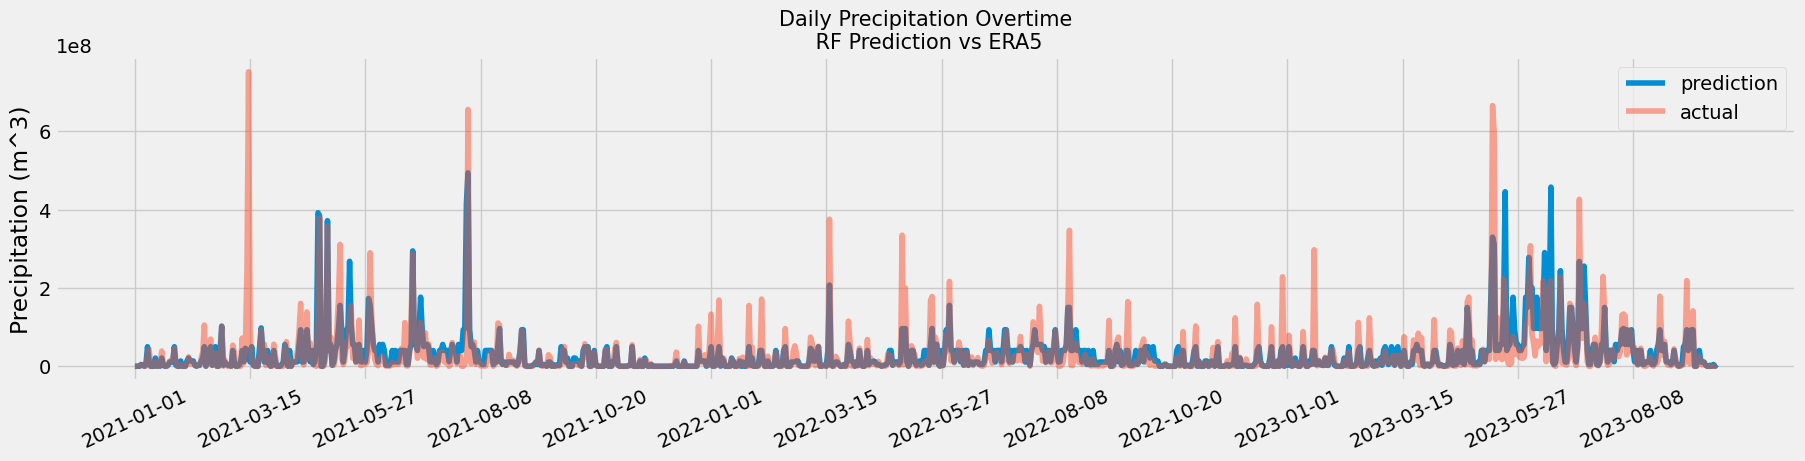

In [57]:
dates = y.loc[(y['Date'] >= "2021-01-01") & (y['Date'] <= "2023-12-31"), y.columns == 'Date'].values.squeeze()
fig, ax =plt.subplots(figsize=(20, 4))
plt.plot(dates,y_pred_val, label = 'prediction')
plt.plot(dates, y_val.values.squeeze(), alpha = 0.5, label = 'actual')
plt.ylabel('Precipitation (m^3)')
plt.title('Daily Precipitation Overtime\n RF Prediction vs ERA5', fontdict={'fontsize':15})
plt.legend()
ax.set_xticks(ax.get_xticks()[::73])
plt.xticks(rotation = 25)

plt.savefig(local_path+'daily_precip_RF_predict_2021_2023.png', dpi = 400,bbox_inches="tight")
print('')

In [58]:
#cacluate RMSE
from sklearn.metrics import root_mean_squared_error
print('RF RMSE:',f'{round(root_mean_squared_error(y_val, y_pred_val),2):,}', 'm^3')
print('No Precip RMSE:',f'{round(root_mean_squared_error([0] * len(y_val), y_pred_val),2):,}', 'm^3')

print('RF RMSE:',f'{round(root_mean_squared_error(y_train, y_pred),2):,}', 'm^3')
print('No Precip RMSE:',f'{round(root_mean_squared_error([0] * len(y_pred), y_pred),2):,}', 'm^3')



RF RMSE: 45,712,874.17 m^3
No Precip RMSE: 61,058,639.34 m^3
RF RMSE: 33,301,546.32 m^3
No Precip RMSE: 61,984,298.5 m^3


In [50]:
y

Date  nfr_precip_m3
0     2000-01-01   1.293943e+06
1     2000-01-02   2.627541e+07
2     2000-01-03   6.351147e+07
3     2000-01-04   6.341063e+04
4     2000-01-05   2.364061e+06
...          ...            ...
8669  2023-09-26   1.372313e+05
8670  2023-09-27   0.000000e+00
8671  2023-09-28   7.055699e+05
8672  2023-09-29   2.347928e+05
8673  2023-09-30   9.213232e+05

[8674 rows x 2 columns]

In [51]:
np.shape(np.append(y_pred,y_pred_val))


(8674,)

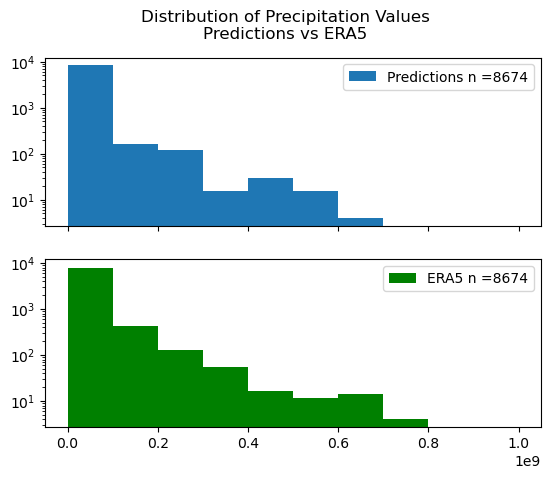

In [52]:
all_predictions = np.append(y_pred,y_pred_val)
binwidth = 100_000_000
bins = range(int(min(y.iloc[:,1])), int(max(y.iloc[:,1])) + binwidth, binwidth)
fig, axs = plt.subplots(2, sharey=True, sharex=True)
axs[0].hist(all_predictions, bins = bins, label = f"Predictions n ={len(all_predictions)}")
axs[0].set_yscale('log')
axs[0].legend()

axs[1].hist(y.iloc[:,1], bins = bins,color = 'green', label = f"ERA5 n ={len(y.iloc[:,1])}")
axs[1].set_yscale('log')
axs[1].legend()

plt.suptitle('Distribution of Precipitation Values\nPredictions vs ERA5')


plt.savefig(local_path+'Histogram_predict_vs_era5.png', dpi = 400,bbox_inches="tight")


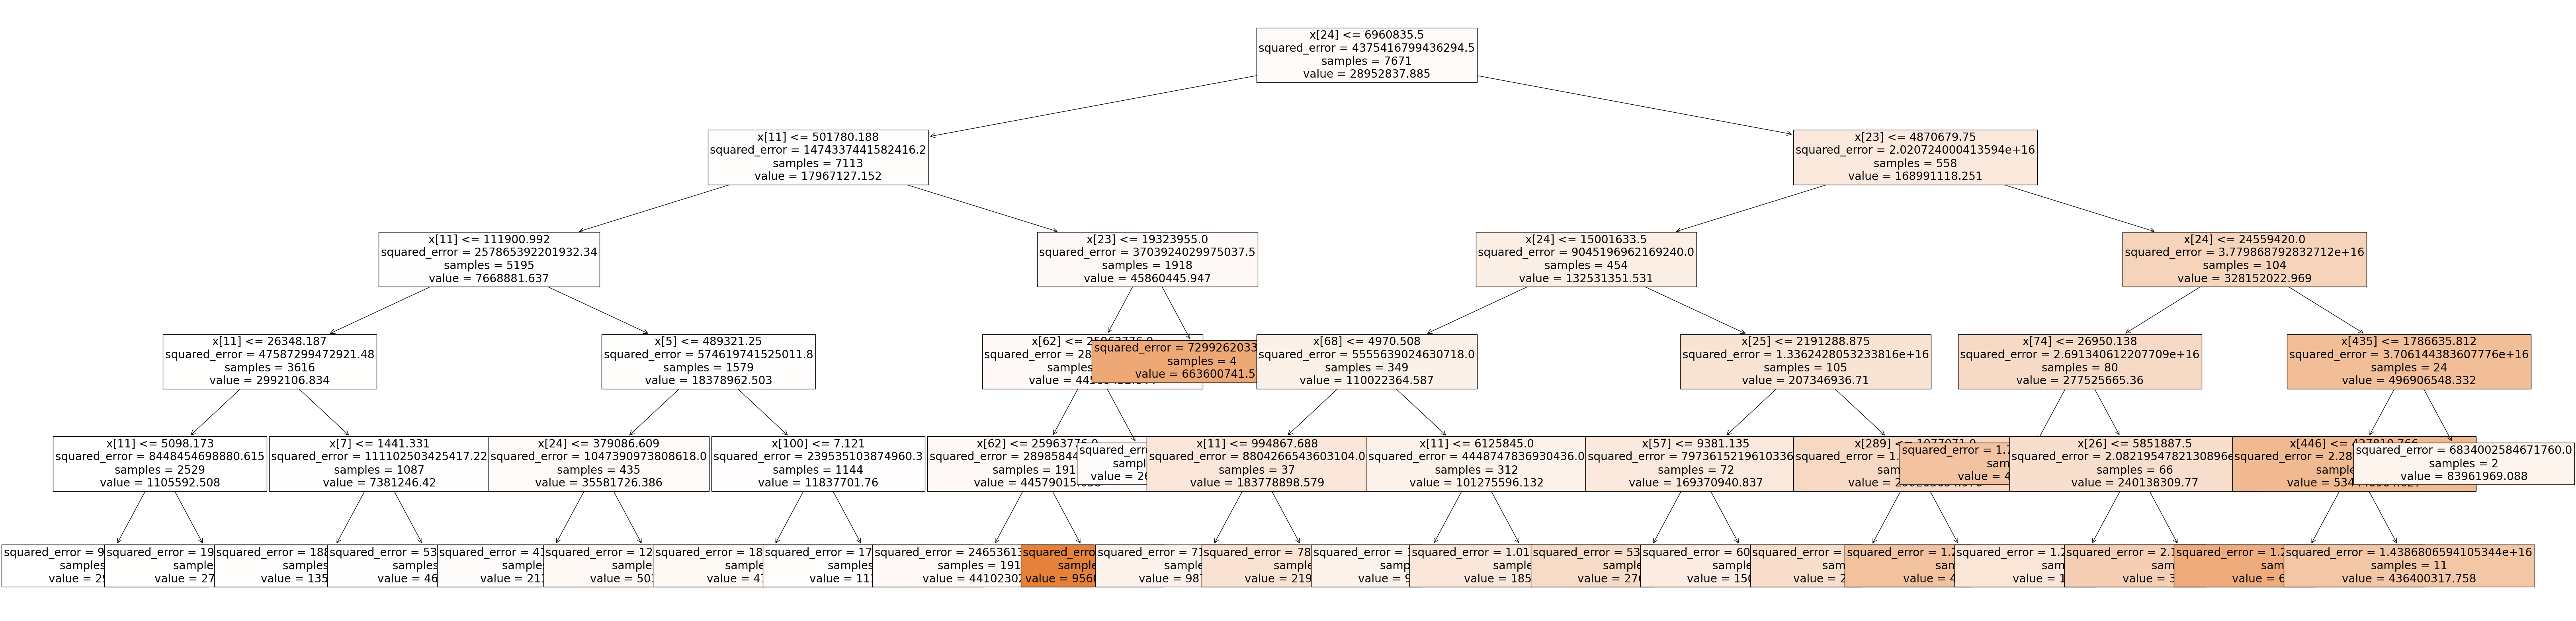

In [53]:
plt.figure(figsize=(80,20))
tree.plot_tree(forest.estimators_[0], filled = True, fontsize=20)
print('')

In [54]:
X_train.iloc[:,11]

0       170407.811859
1       547892.229126
2       374064.360107
3          129.981162
4         6105.731972
            ...      
7666     17275.858059
7667    133167.632690
7668     44527.594147
7669       180.995530
7670      4627.761659
Name: Front Range_e_track_t-0, Length: 7671, dtype: float64

In [55]:
list(X.columns)[1:]

['Other Water_e_track_t-0',
 'Pacific Ocean_e_track_t-0',
 'Gulf of California_e_track_t-0',
 'Atlantic Ocean_e_track_t-0',
 'Gulf of Mexico_e_track_t-0',
 'Other Land_e_track_t-0',
 'Western US_e_track_t-0',
 'Southern US_e_track_t-0',
 'Midwestern US_e_track_t-0',
 'Colorado_e_track_t-0',
 'Eastern Plains_e_track_t-0',
 'Front Range_e_track_t-0',
 'Pikes Peak_e_track_t-0',
 'Arkansas Basin_e_track_t-0',
 'High Mountain Valley_e_track_t-0',
 'Other Water_e_track_t-1',
 'Pacific Ocean_e_track_t-1',
 'Gulf of California_e_track_t-1',
 'Atlantic Ocean_e_track_t-1',
 'Gulf of Mexico_e_track_t-1',
 'Other Land_e_track_t-1',
 'Western US_e_track_t-1',
 'Southern US_e_track_t-1',
 'Midwestern US_e_track_t-1',
 'Colorado_e_track_t-1',
 'Eastern Plains_e_track_t-1',
 'Front Range_e_track_t-1',
 'Pikes Peak_e_track_t-1',
 'Arkansas Basin_e_track_t-1',
 'High Mountain Valley_e_track_t-1',
 'Other Water_e_track_t-2',
 'Pacific Ocean_e_track_t-2',
 'Gulf of California_e_track_t-2',
 'Atlantic Ocea

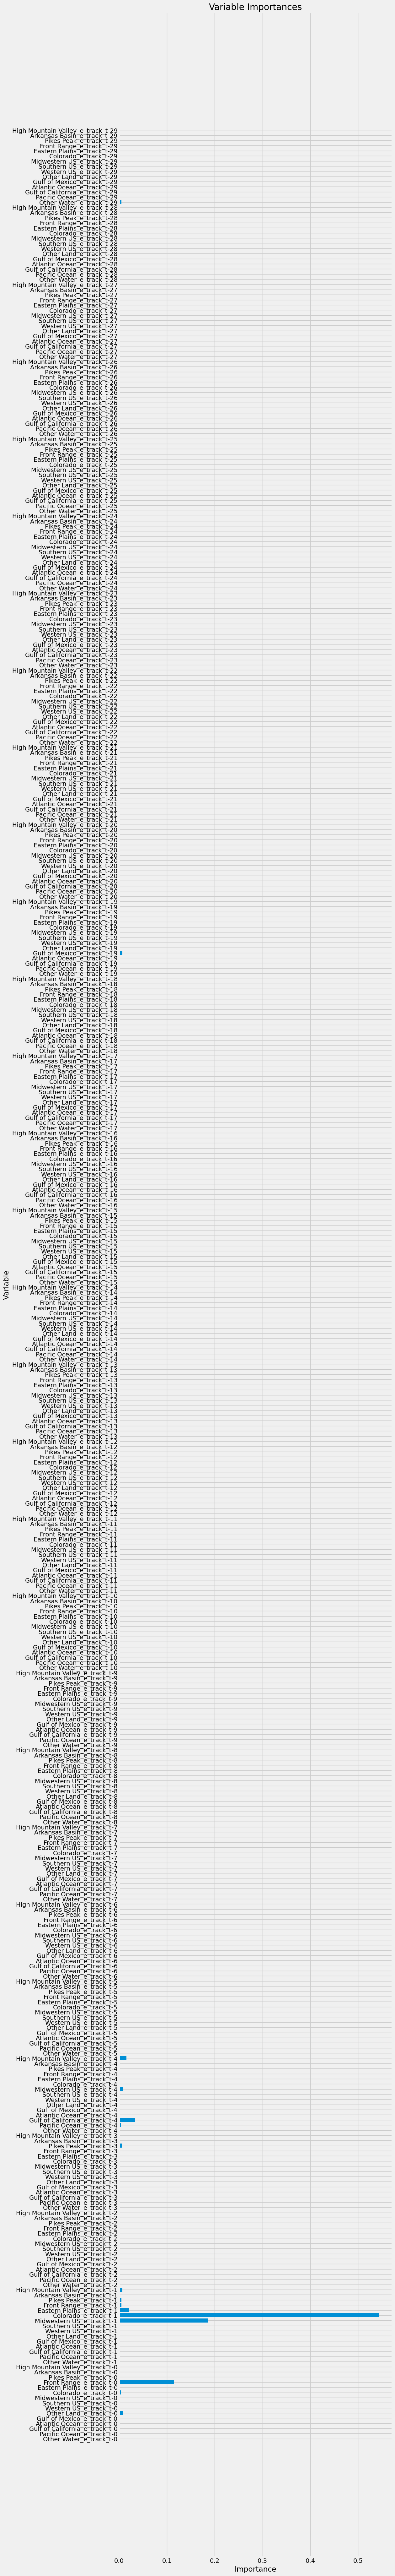

In [66]:
def calc_importances(rf, feature_list):
    ''' Calculate feature importance '''
    # Get numerical feature importances
    importances = list(rf.feature_importances_)

    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    # Print out the feature and importances
    # print('')
    # [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]
    # print('')

    return importances

def plot_feat_importances(importances, feature_list):
    ''' Plot the feature importance calculated by calc_importances '''
    plt.figure(figsize=(10,100))
    # Set the style
    plt.style.use('fivethirtyeight')
    # list of x locations for plotting
    x_values = list(range(len(importances)))
    # Make a bar chart
    plt.barh(x_values, importances)
    # Tick labels for x axis
    plt.yticks(x_values, feature_list)
    # Axis labels and title
    plt.xlabel('Importance'); plt.ylabel('Variable'); plt.title('Variable Importances')

feature_names = list(X.columns)[1:]
importantces_vars = calc_importances(forest, feature_names)
plot_feat_importances(importantces_vars,  feature_names)